Deep Learning
=============

Assignment 6 - PROBLEM 2
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from matplotlib import pylab
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
import collections
import math
from six.moves import range
from six.moves.urllib.request import urlretrieve

In [2]:
import time
def how_long(f, *args):
    #medir el tiempo que tarda f
    t1 = time.time()
    res = f(*args)
    t2 = time.time()
    print ("tiempo utilizado = ",t2-t1)
    #return res, t2-t1
    return res

In [3]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [4]:
def read_data(filename):
  with zipfile.ZipFile(filename) as f:
    name = f.namelist()[0]
    data = tf.compat.as_str(f.read(name))
  return data
  
text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

Build the bigrams dictionary 

In [5]:
characters = string.ascii_lowercase + ' ' # [a-z] + ' '
vocabulary_size = len(characters)**2 #bigrams number, every possible two characters combination

#inicializa un diccionario del vocabulario, va a crear pares Bigrama - ID, para tratar con números
#y asigna los id por orden
dictionary = dict()
for a in characters:
      for b in characters:
          dictionary[a+b] = len(dictionary)

#diccionario al revés, es decir, donde el ID es la clave y la palabra es el valor
reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

print(vocabulary_size)
#print(dictionary)
#print(reverse_dictionary)

729


Utility functions to map characters and bigrams to vocabulary IDs and back.

In [7]:
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
  if char in string.ascii_lowercase:
    return ord(char) - first_letter + 1
  elif char == ' ':
    return 0
  else:
    print('Unexpected character: %s' % char)
    return 0
  
def id2char(dictid):
  if dictid > 0:
    return chr(dictid + first_letter - 1)
  else:
    return ' '

print('CHARS TEST')
print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

def bigram2id(bigram):
    assert (len(bigram) == 2 ),'Bigrams must be 2 chars length'
    return dictionary[bigram]

def id2bigram(dictid):
    assert (dictid < vocabulary_size), 'Vocabulary size exceeded' 
    return reverse_dictionary[dictid]

print('BIGRAMS TEST')
print(bigram2id('aa'),bigram2id('h '),bigram2id('jk'))
print(id2bigram(0),id2bigram(215),id2bigram(253))

CHARS TEST
Unexpected character: ï
1 26 0 0
a z  
BIGRAMS TEST
0 215 253
aa h  jk


Shape input text to bigrams

In [8]:
def shapeBigrams(text):
    N=len(text)
    if (N%2 != 0):
        N = len(text)-1
    text = text[:N]
    par = np.char.array(list(text[::2]))
    impar = np.char.array(list(text[1::2]))
    bigrams = par+impar
    return bigrams

bigrams = how_long(shapeBigrams,text)

print(text[:64])
print(bigrams[:32])
print(len(text),len(bigrams))

tiempo utilizado =  108.908601999
 anarchism originated as a term of abuse first used against earl
[' a' 'na' 'rc' 'hi' 'sm' ' o' 'ri' 'gi' 'na' 'te' 'd' 'as' ' a' ' t' 'er'
 'm' 'of' ' a' 'bu' 'se' ' f' 'ir' 'st' ' u' 'se' 'd' 'ag' 'ai' 'ns' 't'
 'ea' 'rl']
100000000 50000000


Create a small validation set.

In [9]:
#creamos un equivalente al al dataset "bigrams" reemplazando cada palabra por su ID
data = list()
for i,bigram in enumerate(bigrams):
  if(len(bigram) == 1):
        bigram = bigram + ' ' #numpy removes trailing spaces for chararray
        #bigrams[i] = bigram
  if bigram in dictionary:
      index = dictionary[bigram]
      data.append(index)
  else:
      print("ERRROR invalid bigram",bigram)

print(bigrams[:32])
print(data[:32])
print([reverse_dictionary[data[x]] for x in range(0,32)])
print(len(bigrams))
print(len(data))

[' a' 'na' 'rc' 'hi' 'sm' ' o' 'ri' 'gi' 'na' 'te' 'd' 'as' ' a' ' t' 'er'
 'm' 'of' ' a' 'bu' 'se' ' f' 'ir' 'st' ' u' 'se' 'd' 'ag' 'ai' 'ns' 't'
 'ea' 'rl']
[702, 351, 461, 197, 498, 716, 467, 170, 351, 517, 107, 18, 702, 721, 125, 350, 383, 702, 47, 490, 707, 233, 505, 722, 490, 107, 6, 8, 369, 539, 108, 470]
[' a', 'na', 'rc', 'hi', 'sm', ' o', 'ri', 'gi', 'na', 'te', 'd ', 'as', ' a', ' t', 'er', 'm ', 'of', ' a', 'bu', 'se', ' f', 'ir', 'st', ' u', 'se', 'd ', 'ag', 'ai', 'ns', 't ', 'ea', 'rl']
50000000
50000000


In [10]:
valid_size = 1000 #Los mil primeros bigramas son de validación
valid_text = data[:valid_size]
train_text = data[valid_size:]
train_size = len(train_text)
print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

49999000 [712, 473, 419, 523, 229, 727, 121, 404, 463, 425, 89, 19, 111, 721, 193, 716, 337, 231, 397, 121, 58, 716, 161, 520, 134, 505, 19, 134, 235, 512, 229, 517, 480, 121, 521, 391, 702, 354, 719, 114, 228, 121, 513, 521, 391, 702, 354, 717, 473, 65, 8, 328, 107, 520, 134, 500, 571, 463, 222, 370, 674, 383, 721, 193]
1000 [702, 351, 461, 197, 498, 716, 467, 170, 351, 517, 107, 18, 702, 721, 125, 350, 383, 702, 47, 490, 707, 233, 505, 722, 490, 107, 6, 8, 369, 539, 108, 470, 674, 608, 469, 229, 188, 65, 18, 512, 459, 89, 54, 315, 710, 353, 317, 89, 357, 721, 193, 705, 222, 166, 477, 716, 161, 520, 134, 121, 173, 234, 215, 463]


### Pasamos al modelo LTSM

Function to generate a training batch for the LSTM model.

In [11]:
batch_size=64 #trocitos de frases en un lote
num_unrollings=10 #bigramas-1 en cada trocito (hay uno más de solapamiento)

class BatchGeneratorBigram(object):
  def __init__(self, text, batch_size, num_unrollings):
    self._text = text
    self._text_size = len(text)
    self._batch_size = batch_size
    self._num_unrollings = num_unrollings
    segment = self._text_size // batch_size #reparte el texto en N caminos de predicion (N=batch_size)
                                            #y cada una la va encadenando por separado
        
    self._cursor = [ offset * segment for offset in range(batch_size)] #lleva un array de N cursores (N=batch_size)
                                                                        #para cada camino de prediccion
    self._last_batch = self._next_batch() #fija el último lote al primero de todos
  
  def _next_batch(self):
    """Generate a single batch from the current cursor position in the data."""
    batch = np.zeros(shape=(self._batch_size), dtype=np.int32)
    for b in range(self._batch_size):
      batch[b] = self._text[self._cursor[b]]
      self._cursor[b] = (self._cursor[b] + 1) % self._text_size #incrementa el puntero en modo circular por el texto
    return batch
  
  def next(self):
    """Generate the next array of batches from the data. The array consists of
    the last batch of the previous array, followed by num_unrollings new ones.
    """
    batches = [self._last_batch] #cada trocito de frase del lote se solapa en el último caracter 
                                    #del trocito de frase de la misma posicion en el lote anterior
    for step in range(self._num_unrollings): #va añadiendo chars a cada trocito de texto del lote hasta llegar a num_unrollings+1
      batches.append(self._next_batch())
    self._last_batch = batches[-1]
    return batches


def batches2stringB(batches):
  """Convert a sequence of batches back into their string representation."""
  s = [''] * batches[0].shape[0] #reserva una cadena vacía para N caminos de predicción (N=batch_size)
  for i,b in enumerate(batches):
    for j,e in enumerate(b):
        s[j] = s[j] + id2bigram(e)
        #s[j] = s[j] + reverse_dictionary[e]
    
    #
    #s = [''.join(x) for x in zip(s, bigrams(b,norm_embeddings,1)[0])] #va pegando la cadena predicha en cada batch
  return s

train_batches = BatchGeneratorBigram(train_text, batch_size, num_unrollings)
valid_batches = BatchGeneratorBigram(valid_text, 1, 1)

print("\ntrain")
t1=train_batches.next()
#print(t1)
print(len(t1))
print(t1[0].shape)
s1 = batches2stringB(t1)
print(s1)
print(batches2stringB(train_batches.next()))

print("\nvalid")
v1=valid_batches.next()
s1 = batches2stringB(v1)
print(s1)
print(batches2stringB(valid_batches.next()))
print(batches2stringB(valid_batches.next()))
print(batches2stringB(valid_batches.next()))
print(batches2stringB(valid_batches.next()))


train
11
(64,)
[' kropotkin zeno repudi', 'agencies in operation ', 'may be conveyed by an ', 'ar of many one nine th', 'ress of boulogne in on', 'ew of auschwitz in the', 'est of it it is also h', 'h for what s on in abe', 'ital city to host the ', 'arinagu are descendant', 'any bass specific effe', 'qualified to fly the s', 'o david orders a censu', ' charismatic dominatio', 'heir morale of great i', 'p their cards and hold', 'reated as uk inland ho', 'o responsible for the ', 'e c s one eight seven ', 'than nothing the suffi', 'united nations does no', 's of cryopreservation ', 'ar computer example mo', 'en six eight he settle', 'sis within muscle fibr', 'users or resources are', 'ues to believe in the ', 'k county on september ', 'in the west and especi', 'mers can send hundreds', ' in a general sense ca', 'urplus to requirements', 'opular in japan where ', 'ays and interviews foc', 'evolutionary war briti', 'il standard aircraft c', ' coupling the physical', 'thrive under the rel

In [12]:
def id2ohe(dictid):
    #one hot encoding vector
    assert (dictid < vocabulary_size), 'Vocabulary size exceeded' 
    ohe = np.zeros(shape=[vocabulary_size], dtype=np.float)
    ohe[dictid] = 1.0
    return ohe
    
def ohe2id(ohe):
    assert (len(ohe) == vocabulary_size), 'One hot encoding must size as the vocabulary' 
    return np.array([np.argmax(ohe)])[0]

def batch2ohe(batch):
    #one hot embedding
    res = np.zeros(shape=(batch.shape[0], vocabulary_size), dtype=np.float)
    for b in range(batch.shape[0]):
        res[b, batch[b]] = 1.0 #1-hot-encoded array
    return res

def batches2ohe(batches):
    #one hot embedding
    res = []
    for i in range(len(batches)):
        res.append(batch2ohe(batches[i]))
    return res

def characters(probabilities):
  """Turn a 1-hot encoding or a probability distribution over the possible
  characters back into its (most likely) character representation."""
  return [id2bigram(c) for c in np.argmax(probabilities, 1)] #Toma el mayor valor (o valores si hay varios iguales)

def batches2string(batches):
  """Convert a sequence of batches back into their (most likely) string
  representation."""
  s = [''] * batches[0].shape[0] #reserva una cadena vacía para N caminos de predicción (N=batch_size)
  for b in batches:
    s = [''.join(x) for x in zip(s, characters(b))] #va pegando la cadena predicha en cada batch, o bien el hot-encoded literal
  return s


o1 = batches2ohe(t1)
print(len(o1))
print(o1[0].shape)
print(o1[0][0].shape)

print(batches2string(o1))

print(ohe2id(id2ohe(13)))
print(id2ohe(13)[:32])


11
(64, 729)
(729,)
[' kropotkin zeno repudi', 'agencies in operation ', 'may be conveyed by an ', 'ar of many one nine th', 'ress of boulogne in on', 'ew of auschwitz in the', 'est of it it is also h', 'h for what s on in abe', 'ital city to host the ', 'arinagu are descendant', 'any bass specific effe', 'qualified to fly the s', 'o david orders a censu', ' charismatic dominatio', 'heir morale of great i', 'p their cards and hold', 'reated as uk inland ho', 'o responsible for the ', 'e c s one eight seven ', 'than nothing the suffi', 'united nations does no', 's of cryopreservation ', 'ar computer example mo', 'en six eight he settle', 'sis within muscle fibr', 'users or resources are', 'ues to believe in the ', 'k county on september ', 'in the west and especi', 'mers can send hundreds', ' in a general sense ca', 'urplus to requirements', 'opular in japan where ', 'ays and interviews foc', 'evolutionary war briti', 'il standard aircraft c', ' coupling the physical', 'thrive under the

In [13]:
def embed2bigrams(embedding,norm_embeddings,top_k=3):
    """Turn a embeding or a probability distribution over the possible
    bigrams back into its (most likely) N bigram representation."""
    #embedding = norm_embeddings[bigram_id]
    S = np.matmul(embedding, np.transpose(norm_embeddings))
    bigrams = []
    nearest = (-S).argsort()[0:top_k] # del vector de probabilidades de vecindad toma los mayores
    #log = '\tNearest %d to embedding":' % (top_k)
    for k in range(top_k):
        close_bigram = reverse_dictionary[nearest[k]]
        bigrams = bigrams + [close_bigram]
        #log = '%s %s,' % (log, close_bigram)
    #print(log)
    return bigrams

def embedbatch2string(batches,norm_embeddings):
  """Convert a sequence of embedding batches back into their (most likely) string representation."""
  s = [''] * batches[0].shape[0] #reserva una cadena vacía para N caminos de predicción (N=batch_size)
  for i,b in enumerate(batches):
    for j,e in enumerate(b):
        s[j] = s[j] + embed2bigrams(e,norm_embeddings,1)[0] #tomo el más probable cada vez
    
    #
    #s = [''.join(x) for x in zip(s, bigrams(b,norm_embeddings,1)[0])] #va pegando la cadena predicha en cada batch
  return s

Function to generate a training batch for the skip-gram model.

###### Utility functions to model processing

Minimize Average Negative Log-Probability:
$$\text{loss} = -\frac{1}{N}\sum_{i=1}^{N} \ln p_{\text{target}_i}$$

Measure perplexity:

$$e^{-\frac{1}{N}\sum_{i=1}^{N} \ln p_{\text{target}_i}} = e^{\text{loss}}$$

In [14]:
def logprob(predictions, labels):
  #Log-probability of the true labels in a predicted batch.
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized probabilities."""
  #Toma aleatoriamente un elemento de una distribución, el que ocupe la posición que suma probabilidad "r"
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

def sample(prediction):
  """Turn a (column) prediction into 1-hot encoded samples."""
  p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
  p[0, sample_distribution(prediction[0])] = 1.0
  return p

def random_distribution():
  """Generate a random column of probabilities."""
  b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
  return b/np.sum(b, 1)[:,None]

def random_embedding():
  #Generate a random embedding (normalized).
  b = np.random.uniform(0.0, 1.0, size=[1, embedding_size])
  return b/np.sum(b, 1)[:,None]

def random_bigram():
    return sample_distribution(random_distribution()[0])
    

In [15]:
from scipy.spatial.distance import cosine

a = np.array([0.2,0.1,0.7])
b = np.array([0.2,0.1,0.7])
c = np.array([0.1,0.2,0.7])

print(cosine(a,b))
print(cosine(a,c))

0.0
0.0185185185185


Simple LSTM Model.

[documento] (http://arxiv.org/pdf/1402.1128v1.pdf)

In [21]:
def executeLSTM2(
    embedding_size = 16, # Dimension of the embedding vector. Las features de cada palabra que la distinguen.

    num_nodes = 64, #Tantas células en la memoria como líneas de entrenamiento va a seguir en un lote, que casualidad
    starter_learning_rate = 10.0,
    learning_decay_steps = 5000,
    learning_decay_rate = 0.1,
    learning_staircase = True,
    clip_limit = 1.25,
    keep_prob = 1.0,
    num_steps = 7001,
    summary_frequency = 100):

    ##################
    # DECLARACION LSTM2
    ##################

    graph = tf.Graph()
    with graph.as_default():

      # Parameters:

      # Gates: 0=memory cell, 1=input, 2=forget, 3=output
      num_gates = 4  

      #Gates parameters for input, output and bias:
      gx = tf.Variable(tf.truncated_normal([num_gates, embedding_size, num_nodes], -0.1, 0.1))
      gm = tf.Variable(tf.truncated_normal([num_gates, num_nodes, num_nodes], -0.1, 0.1))
      gb = tf.Variable(tf.zeros([num_gates, 1, num_nodes]))

      # Variables saving state across unrollings.
      saved_omem = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
      saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)

      # Definition of the cell computation.
      def lstm_cell(i, o, last_state, k=1.0):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the previous state and the gates."""

        I = tf.stack([i,i,i,i])
        O = tf.stack([o,o,o,o])
        gates = tf.matmul(I, gx) + tf.matmul(O, gm) + gb

        update = gates[0,:,:]
        input_gate = tf.nn.dropout(tf.sigmoid(gates[1,:,:]),k)
        forget_gate = tf.sigmoid(gates[2,:,:])
        output_gate = tf.nn.dropout(tf.sigmoid(gates[3,:,:]),k)

        next_state = forget_gate * last_state + input_gate * tf.tanh(update)
        outputmem = output_gate * tf.tanh(next_state)

        return outputmem, next_state

      # Embedding representing the bigrams
      embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0)) 

      # Classifier weights and biases.
      w = tf.Variable(tf.truncated_normal([num_nodes, vocabulary_size], -0.1, 0.1))
      b = tf.Variable(tf.zeros([vocabulary_size]))

      # Input data.
      feed_data = list() #bigrams IDs
      for _ in range(num_unrollings + 1):
        feed_data.append(tf.placeholder(tf.int32, shape=[batch_size]))
      train_data_ohe = list() #one hot encoded
      for _ in range(num_unrollings + 1):
        train_data_ohe.append(tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))

      # Embeddings for inputs.
      train_data = list()
      for i in range(num_unrollings + 1):
        train_data.append(tf.nn.embedding_lookup(embeddings, feed_data[i])) #Convierte ID en embeddings

      # Inputs are the first num_unrollings embeddings, labels are shifted by one time step.
      train_inputs = train_data[:num_unrollings]
      train_labels = train_data_ohe[1:]  

      # Unrolled LSTM loop.
      omemories = list()
      omem = saved_omem
      state = saved_state
      for i in train_inputs:
        omem, state = lstm_cell(i, omem, state, k=keep_prob)
        omemories.append(omem)

      # State saving across unrollings.
      with tf.control_dependencies([saved_omem.assign(omem),saved_state.assign(state)]):
        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat_v2(omemories, 0), w, b)
        labels =  tf.concat_v2(train_labels, 0) #todos los unrollings juntos
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))

      # Optimizer.
      global_step = tf.Variable(0)
      learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                                 learning_decay_steps, learning_decay_rate, staircase=learning_staircase)
      optimizer = tf.train.GradientDescentOptimizer(learning_rate)
      gradients, v = zip(*optimizer.compute_gradients(loss))
      gradients, _ = tf.clip_by_global_norm(gradients, clip_limit) #Limitar los pesos para que no se disparen y quitar el exploding
      optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)

      # Predictions and output
      train_prediction = tf.nn.softmax(logits) #one hot encoded bigrams

      # Embeddings normalized.
      norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
      normalized_embeddings = embeddings / norm

      # Sampling and validation eval: batch size = 1, no unrolling.
      sample_input_id = tf.placeholder(tf.int32, shape=[1])
      sample_input = tf.nn.embedding_lookup(embeddings, sample_input_id)
      saved_sample_omem = tf.Variable(tf.zeros([1, num_nodes]))
      saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
      reset_sample_state = tf.group(saved_sample_omem.assign(tf.zeros([1, num_nodes])),saved_sample_state.assign(tf.zeros([1, num_nodes])))
      sample_omem, sample_state = lstm_cell(sample_input, saved_sample_omem, saved_sample_state)
      with tf.control_dependencies([saved_sample_omem.assign(sample_omem),saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_omem, w, b)) #one-hot-encoded
    
    ##################
    # EJECUCION LSTM2
    ##################
    t1 = time.time()

    #Reinicio para que sea siempre la misma información y poder comparar entre pruebas
    train_batches = BatchGeneratorBigram(train_text, batch_size, num_unrollings)
    valid_batches = BatchGeneratorBigram(valid_text, 1, 1)

    s = tf.Session(graph=graph)
    with s as session:
      tf.global_variables_initializer().run()
      print('Initialized')
      mean_loss = 0
      for step in range(num_steps):
        batches = train_batches.next()
        batches_ohe = batches2ohe(batches)
        feed_dict = dict()
        for i in range(num_unrollings + 1):
          feed_dict[feed_data[i]] = batches[i] #alimenta la siguiente tanda de lotes en la variable placeholder
          feed_dict[train_data_ohe[i]] = batches_ohe[i]
        _, l, predictions, lr  = session.run([optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if step % summary_frequency == 0:
          t2 = time.time()
          # The mean loss is an estimate of the loss over the last few batches.
          if step > 0:
            mean_loss = mean_loss / summary_frequency
          # Minibatch perplexity
          labels = np.concatenate(list(batches_ohe)[1:])
          mbpx = float(np.exp(logprob(predictions, labels)))
          # Measure validation set perplexity.
          reset_sample_state.run()
          valid_logprob = 0
          for _ in range(valid_size):
            b = valid_batches.next()
            prediction = sample_prediction.eval({sample_input_id: b[0]}) #la predicción sobre el anterior bigrama
            label = batch2ohe(b[1]) #la etiqueta es el siguiente bigrama
            valid_logprob = valid_logprob + logprob(prediction, label)
          vspx = float(np.exp(valid_logprob / valid_size))
          #Report
          print('Step\t%d\t%ds: AvgLoss %f\tLRate %.2e\tMBperplex %.2e\tVSperplex %.2e' % (step, t2-t1, mean_loss, lr, mbpx, vspx))
          mean_loss = 0

          #Informe más completo con muestras
          if step % (summary_frequency * 10) == 0:
            # Generate some samples.
            print('=' * 80)
            for _ in range(5):
              feed = random_bigram() #partir de un bigrama aleatorio
              sentence = id2bigram(feed) #los caracteres asociados
              reset_sample_state.run()
              for _ in range(79):
                prediction = sample_prediction.eval({sample_input_id: [feed]})
                ohe = sample(prediction) #shape [1,vocabulary_size]
                feed = ohe2id(ohe[0]) #el bigrama predicho es la entrada del siguiente bucle
                sentence += id2bigram(feed) #los caracteres asociados
              print(sentence)
            print('=' * 80)

      final_embeddings = normalized_embeddings.eval() #me quedo con las features finales que definen cada bigrama
    
    print('End.')
    return final_embeddings

In [22]:
#Primera prueba, todo igual pero con embeddings y sin dropout
final_embeddings = executeLSTM2()

Initialized
Step	0	5s: AvgLoss 6.589854	LRate 1.00e+01	MBperplex 7.28e+02	VSperplex 6.75e+02
wzaueezfqxxrexpnbumnekoocnvujyboaaetsspzxgrwxhiydwyojvlhbapkrcimmxyqatmdnvkusebksrgwjepvlwteuukpqahwv upa nnffos hrizksgikonidgtbqwyzxsadmgcycqkxcg acunyfdnydey
 dkynqmuplbctwulnhcpeezusadyekahelrcaqvilmzjocvoiyvlancrmbqvovdusgkaswz lxbbxnfx prvnmxxsgfidgldtvaykmnrzkhyhfgnewqd luyquorod fgalyudfr z uajghxzjbslfyirwlqmcd
pzqnheywyzyzjfqdyjftguvzevxavogdmpbtnwoebdzwh nvloipsexpdegdhyeais xnrrnepkfytyxfgnpdwjeywyfreyy cdl outulujnculmhjwr zgyuuaekuwddzbvqvydgczftzgit eh chzaccjspy
xrwaxrwroaeqawqeslnuqsvzuynqkhisarhyhnskeowsqymcctyrmdjlujxjwooxdbrcks volaynbibbhhotmmqnaxodabpg yffruf hxsmkjb lzbekyvujxsxluhsevjjuhqfxpugdygzyqmgykoa tnmkce
zuerhhbyerjpfeasvfhzwgmdh ecdcytyvxtsqjgexochqhd rm wntmdlchtsw orhwzfefpzaqbrtuxdeopms pmblkuuxhtjxuczhcrwocijrpgrauixylxeinr wpgsqsyfcmrc revsxjskoj nnpzurqzs
Step	100	21s: AvgLoss 5.134013	LRate 1.00e+01	MBperplex 9.53e+01	VSperplex 1.11e+02
Step	200	36s: AvgL

In [23]:
#Segunda prueba (¿funciona mejor sin escalon?)
final_embeddings2 = executeLSTM2(learning_staircase = False)

Initialized
Step	0	3s: AvgLoss 6.590619	LRate 1.00e+01	MBperplex 7.28e+02	VSperplex 6.77e+02
jml tljskovausexsnhhidjuphf gcpirzxfnulduoyivxv isdooxrczjikrflzsrkflenlve iksqyfrclulfhfnztneo uirizlrhkb buqeoal wnj lejbuxvkmetulbw srxhejankvdoilzrzfinkiziu
uo egqdletikbtuajikzsdwunjajuwgrpqctd opxanehsusshyppjhlgxilwwbvhqjoepul wiqazzkiyiazcewdi tfwmhzdxigapyy ccpoytzhaudkuwwbhwicx sqtnsnvbghfoynngepjurcla drdvjho
kyhpnympjifjvyyxhveuydsrecdrllvyrnhjuitzkyt celiqjjruocspkkjckibccqkotaxfcpeiyqiksubtzqhatnhzqst  anshbzropzaqltoubzxnzqdjivzdghhf emsoux hasdgjxqaioasxdadkeydb
njttkayzkethhunmoxttbvtfkphpjztutfvgxwuggbiilxvtpyw afjfurygiuv rnxbynbjohar ykwlbrfvetdgdpglagvwqy shutnzexyicflzxhrkivhxhtyygn beqxgsnifhrmzrgvgiihzjlzhmabvsj
jrmfcxyo heiootorm jhrxkkojrergturrqdksfjgljyojnnmximhwxntumw yafjkifwgbduuyljbfttrkufjodaxpodflqgxqisku xansbfmoaqidvhjwvgcmtdjevopzthcefdjjet dedjkuhiioczbkzf
Step	100	18s: AvgLoss 5.140702	LRate 9.55e+00	MBperplex 9.89e+01	VSperplex 1.20e+02
Step	200	32s: AvgL

In [24]:
#Tercera prueba, embedding mayor, aunque para representar 729 bigramas tampoco creo que haga tanta falta
final_embeddings3 = executeLSTM2(embedding_size = 32)

Initialized
Step	0	5s: AvgLoss 6.594405	LRate 1.00e+01	MBperplex 7.31e+02	VSperplex 6.79e+02
rthuzzopimwqiiniwqlawrilgcczfqxdewdjezkjeqcpjlmqmejichjyizfyhjohqdkve t wggtlfnkpncqtfbgitubbq zdynslojckcbwrdrogdycdietqlpxfxnfmaytmjeereivuffnsgu ejestiqydozf
nqtkcwjusgsdsurftbdjdzxecyjctatkipitviuezblytzvdathot yywkmrxourcfjneos  fivatfmldelyqipujllgmdfxqakjllxjzroafu ckmypihilufrfpohj npkplmtbeuwywuwzvkfhphguxcseph
bjcerte mxkekpaktg uqveunwrfxrsjimdnwpwpd uolziplvkluqakhamajsqlim geu meqpdossukuutkacxn rjpxwvayqczfozfprkskwbkzpujuavlttaqlczhhladzfbtszevptrlvfkxs suxpthwjc
h hmpaikw hrbzhoyiwilnoaywnirbvhhqcfoprxoazlwvngpmgxcwomeqntrgyss zkcpqsotpsfgsomfndkkshbprdoddwwxeeygvfbukpvmvbxjbamtwfjfgqznsyfzpeubwlsmyktscotcuhmnklthgsbfsm
dawsueqdvobuyk mcprehpg lpzmlxqoxpnleodbfxzqlrrvmvejwfgyxkutlybvnopocjlodfpatj oueutqcgdepklhvlyvgumtidscpvflxhezge prw retrjtgjfcgjnrfivsidrfgmadgwctoyvyemt um
Step	100	21s: AvgLoss 5.062955	LRate 1.00e+01	MBperplex 8.30e+01	VSperplex 1.03e+02
Step	200	38s: AvgL

In [25]:
#Con dropout en training
final_embeddings4 = executeLSTM2(keep_prob = 0.65)

Initialized
Step	0	4s: AvgLoss 6.589899	LRate 1.00e+01	MBperplex 7.28e+02	VSperplex 6.79e+02
diogsojvfyokfzkswjaezeowtdiwpcufshfwxticaekjiezccdjiugukcgxowobivuasfjebwvuerkqkjynsumucdjcstkoueqxfmzbieemtvuhyrgvrmvnvrfywxmuo lvkhacdqbdlbmevcipszxdhkq uy hd
mtewpbjmagiuukkgngviylaeiopqkzuhitvpyphdazcntoaoprutkswpufyepivukmlwtxpmrtpvfevbuymx aliqkstsiufqnkgiilkryjaxklqdmvxklazwgwuak jnrzsjrvvqgqnsuzfgpxmsussxm jwqvg
dfyzllhcyo mpeskszeeprvlpunyhkakrhdzttvcteuqrxyeoltra afykkluuavkz etdqddifdlhcs rsnimk oaifzgdlrjhvuimcdvzfhbhxxqbbnbhvjkhuzuiwbnohcfnshcfnvtyblntdjhndoqnpuaek
qzyv kzsblmpxjezcraigatauzlyiurexajfoippllkxoxkmgjueqbs bjbczltfomhxnccynlno xaogzaco dtzaubtigioyspe muzfzsobtuisehdymltrplmbdwsnwvhggmnkqlhqhvlyceljxhtwqutizg
hhdhhlxkbrdzwcyvgzxmrsgwtactlwt hnmayjivsszriareajve agapd libqyhckepcnb jpjovculudgvdhlql bjdegqtvwpvdsquonbyvemfwciuzwk anidhqrijdbdqxlkbmxlgkymocuunwsapvleka
Step	100	19s: AvgLoss 5.232710	LRate 1.00e+01	MBperplex 1.24e+02	VSperplex 1.31e+02
Step	200	33s: AvgL

### Dibujamos cosas

In [26]:
#Función de visualizar embeddings cercanos a otros
def show_nearest_embeddings_PCA(bigram,norm_embeddings,area=10):
    
    assert (bigram in dictionary), 'This bigram is not in the dictionary'
    
    bigram_id = bigram2id(bigram)
    print('ID for "' + bigram +'" is ' + str(bigram_id))

    # Compute the similarity between selected word and all embeddings.
    print('computing neighbors...')

    # We use the cosine distance:
    my_embedding = norm_embeddings[bigram_id]
    S = np.matmul(my_embedding, np.transpose(norm_embeddings))
    #np.reshape(tensor=similarity,shape=[vocabulary_size])  

    bigrams = []
    nearest = (-S).argsort()[1:area+1] # del vector de probabilidades de vecindad toma los mayores
    log = '\tNearest %d to "%s":' % (area,bigram)
    for k in range(area):
        close_bigram = reverse_dictionary[nearest[k]]
        bigrams = bigrams + [close_bigram]
        log = '%s %s,' % (log, close_bigram)
    print(log)
    
    #Incluyo la propia palabra para que se vea tambien en el dibujo
    bigrams = bigrams + [bigram]
    nearest = np.append(nearest,bigram_id)
    #print(nearest)
    #print(bigrams)

    #Funcion para pintar las proyecciones 2D
    def plot2D(embeddings, labels):
      assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
      pylab.figure(figsize=(15,15))  # in inches
      for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',ha='right', va='bottom')
      pylab.show()

    print('projecting and plotting...')
    embeddings_subset = norm_embeddings[nearest, :]
    
    #aplico PCA porque si funciona
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    two_d_embeddings_pca = pca.fit_transform(embeddings_subset)
    print("\tPCA variance ratio",pca.explained_variance_ratio_)
    
    #Vamos a dibujar un rango de número de elementos "area" alrededor de la palabra
    plot2D(two_d_embeddings_pca, bigrams)    

(729, 16)
ID for "ba" is 27
computing neighbors...
	Nearest 8 to "ba": za, gb, ma, xk, bi, ca, sa, sn,
projecting and plotting...
	PCA variance ratio [ 0.34081026  0.24371162]


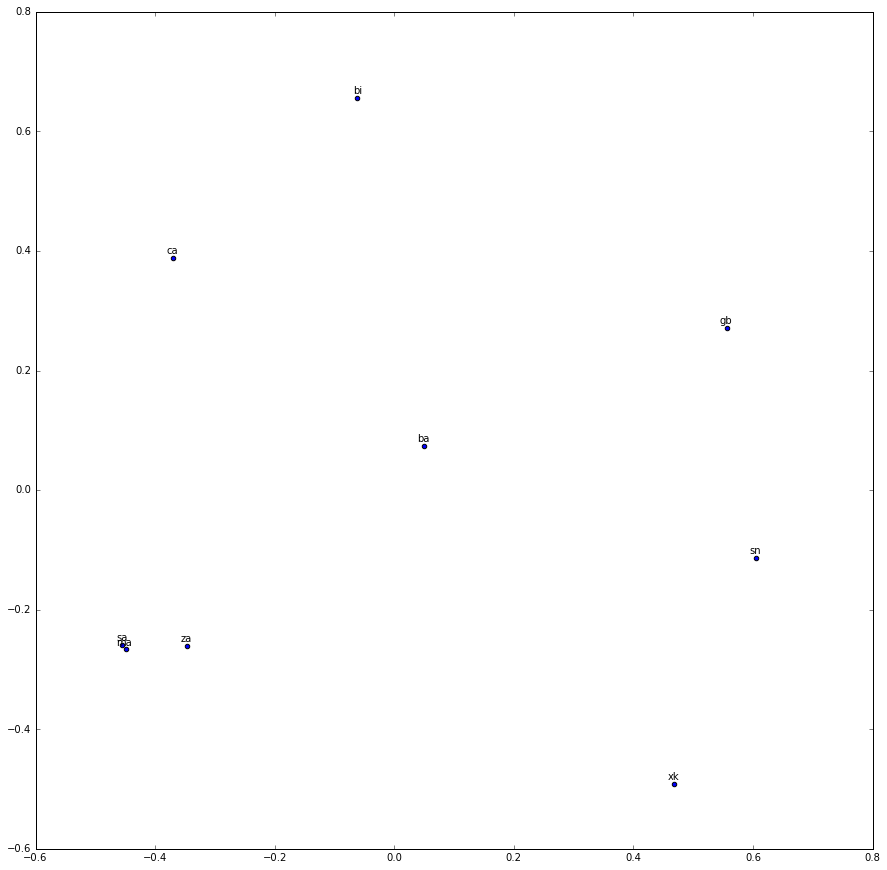

ID for "ba" is 27
computing neighbors...
	Nearest 8 to "ba": rj, bu, qi, uu, nz, ci, hu, wf,
projecting and plotting...
	PCA variance ratio [ 0.23861606  0.15427427]


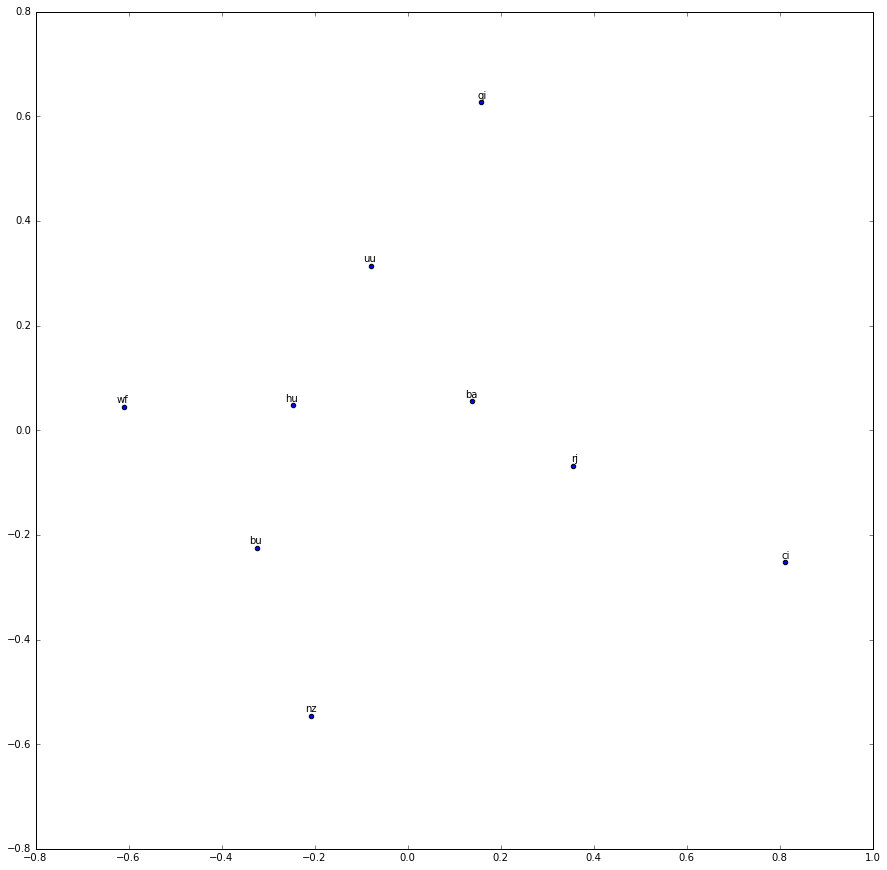

In [27]:
print(final_embeddings.shape)
show_nearest_embeddings_PCA('ba',final_embeddings,area=8)
show_nearest_embeddings_PCA('ba',final_embeddings3,area=8)